<a href="https://colab.research.google.com/github/thisisindrajit/Using-Deep-CNN-to-enhance-low-res-photos-to-match-the-quality-of-DSLR-cameras/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References and citation

This notebook contains references for code from this repository: https://github.com/aiff22/DPED.git

**This project is for educational purposes only.**

<br>
<hr>
<br>

Citation:

<pre>
@inproceedings{ignatov2017dslr,
  title={DSLR-Quality Photos on Mobile Devices with Deep Convolutional Networks},
  author={Ignatov, Andrey and Kobyshev, Nikolay and Timofte, Radu and Vanhoey, Kenneth and Van Gool, Luc},
  booktitle={Proceedings of the IEEE International Conference on Computer Vision},
  pages={3277--3285},
  year={2017}
}
</pre>



# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import imageio
import PIL #pillow
import tensorflow as tf
from tensorflow import keras
from __future__ import print_function
import scipy
import scipy.io
import os
import sys
import scipy.stats as st
import matplotlib.pyplot as plt

from functools import reduce

#tensorflow version
print(tf.__version__)

2.4.1


# Loading the dataset

In [ ]:
#helper functions to load batch training data and test data

#function to load test data
def load_test_data(phone, dped_dir, IMAGE_SIZE):

    #print(phone + " " + dped_dir + " " + str(IMAGE_SIZE))
    
    test_directory_phone = dped_dir + str(phone) + '/test_data/patches/' + str(phone) + '/'
    test_directory_dslr = dped_dir + str(phone) + '/test_data/patches/canon/'

    #finding no of test images
    NUM_TEST_IMAGES = len([name for name in os.listdir(test_directory_phone)
                           if os.path.isfile(os.path.join(test_directory_phone, name))])
    
    #print(NUM_TEST_IMAGES) #201 
    #print(IMAGE_SIZE) #30000

    #empty arrays with no of rows = number of test images and no of columns = 100*100*3
    test_data = np.zeros((NUM_TEST_IMAGES, IMAGE_SIZE))
    test_answ = np.zeros((NUM_TEST_IMAGES, IMAGE_SIZE))

    for i in range(0,NUM_TEST_IMAGES):
        
        I = np.asarray(imageio.imread(test_directory_phone + str(i) + '.jpg'))
        I = np.float16(np.reshape(I, [1, IMAGE_SIZE]))/255
        test_data[i, :] = I
        
        I = np.asarray(imageio.imread(test_directory_dslr + str(i) + '.jpg'))
        I = np.float16(np.reshape(I, [1, IMAGE_SIZE]))/255
        test_answ[i, :] = I

        if i % 100 == 0:
            print(str(round(i * 100 / NUM_TEST_IMAGES)) + "% done")

    return test_data, test_answ

#function to load training data
def load_batch(phone, dped_dir, TRAIN_SIZE, IMAGE_SIZE):

    #print(phone + " " + dped_dir + " " + IMAGE_SIZE)

    train_directory_phone = dped_dir + str(phone) + '/training_data/' + str(phone) + '/'
    train_directory_dslr = dped_dir + str(phone) + '/training_data/canon/'

    #finding no of training images
    NUM_TRAINING_IMAGES = len([name for name in os.listdir(train_directory_phone)
                               if os.path.isfile(os.path.join(train_directory_phone, name))])

    #if TRAIN_SIZE == -1 then load all images

    if TRAIN_SIZE == -1:
        TRAIN_SIZE = NUM_TRAINING_IMAGES
        #here np.arange returns an array with values from 0 to TRAIN_SIZE-1 -> [0,1,2,3.....]
        TRAIN_IMAGES = np.arange(0, TRAIN_SIZE)
    else:
        #randomly selecting TRAIN_SIZE no of images from total no of training images
        TRAIN_IMAGES = np.random.choice(np.arange(0, NUM_TRAINING_IMAGES), TRAIN_SIZE, replace=False)

    #empty arrays with no of rows = number of training images and no of columns = 100*100*3
    train_data = np.zeros((TRAIN_SIZE, IMAGE_SIZE))
    train_answ = np.zeros((TRAIN_SIZE, IMAGE_SIZE))

    i = 0

    for img in TRAIN_IMAGES:

        I = np.asarray(imageio.imread(train_directory_phone + str(img) + '.jpg'))
        I = np.float16(np.reshape(I, [1, IMAGE_SIZE])) / 255
        train_data[i, :] = I

        I = np.asarray(imageio.imread(train_directory_dslr + str(img) + '.jpg'))
        I = np.float16(np.reshape(I, [1, IMAGE_SIZE])) / 255
        train_answ[i, :] = I

        i += 1
        if i % 100 == 0:
            print(str(round(i * 100 / TRAIN_SIZE)) + "% done")

    return train_data, train_answ

#test_data, test_answ = load_test_data("sony", "dped/", 100*100*3)

test_data, test_ans = load_test_data("sony", "drive/MyDrive/Innovation Practices Lab/dped_small/", 100*100*3)
print("Test ans")
print(test_ans)

train_data, train_ans = load_batch("iphone", "drive/MyDrive/Innovation Practices Lab/dped_small/", -1, 100*100*3)
print("Training ans")
print(train_ans)

0% done


# VGG 19 pretrained model (conversion of MATLAB file to Neural Network)

In [ ]:
#helper functions for vgg 19 conversion

def conv_layer_vgg(input, weights, bias):
  conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1), padding='SAME')
  return tf.nn.bias_add(conv, bias)

def pool_layer_vgg(input):
  return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME')

def preprocess(image):
  return image - IMAGE_MEAN

#------------------------------------------------------------------

IMAGE_MEAN = np.array([123.68 ,  116.779,  103.939])

#conversion of matlab file to neural network
def net(path_to_vgg_net, input_image):

  layers = (
      'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

      'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

      'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
      'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

      'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
      'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

      'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
      'relu5_3', 'conv5_4', 'relu5_4'
  )

  data = scipy.io.loadmat(path_to_vgg_net)
  weights = data['layers'][0]

  net = {}

  current = input_image
  
  for i, name in enumerate(layers):
      layer_type = name[:4]
      
      if layer_type == 'conv':
          kernels, bias = weights[i][0][0][0][0]
          kernels = np.transpose(kernels, (1, 0, 2, 3))
          bias = bias.reshape(-1)
          current = conv_layer_vgg(current, kernels, bias)

      elif layer_type == 'relu':
          current = tf.nn.relu(current)

      elif layer_type == 'pool':
          current = pool_layer_vgg(current)
  
      net[name] = current

  return net

#test
img = plt.imread('./1.jpg')
print(net(vgg_dir, preprocess(tf.reshape(tf.cast(img, dtype= tf.float32), [-1,100,100,3]) * 255)))

{'conv1_1': <tf.Tensor: shape=(1, 100, 100, 64), dtype=float32, numpy=
array([[[[-1.21871000e+05,  1.48735459e+04,  1.02221309e+04, ...,
          -4.62733633e+04,  1.06243965e+04, -7.90739307e+03],
         [-7.63794453e+04,  1.90717227e+04,  3.39069141e+03, ...,
          -7.61349297e+04, -6.09476133e+04, -5.55804297e+04],
         [-7.67979609e+04,  1.88410332e+04,  3.32683887e+03, ...,
          -7.54851406e+04, -5.98757695e+04, -5.48697031e+04],
         ...,
         [-7.54255000e+04,  1.88017227e+04,  3.39952563e+03, ...,
          -7.69444766e+04, -6.24495547e+04, -5.59800781e+04],
         [-7.55880703e+04,  1.83453672e+04,  2.96473315e+03, ...,
          -7.57042188e+04, -6.14352344e+04, -5.57963438e+04],
         [ 1.17021992e+04,  1.29036074e+04,  8.95212988e+03, ...,
          -4.80403320e+04, -6.56317109e+04, -2.45574668e+04]],

        [[-9.61962109e+04,  2.46430645e+04,  3.23162129e+04, ...,
          -7.29781328e+04,  7.71674141e+04,  5.66570781e+04],
         [ 3.1080

# Helper functions for models

In [ ]:
#helper function to define the weight variable
def weight(shape, name):

  weight_var = tf.compat.v1.truncated_normal(shape, stddev=0.01)  
  return tf.Variable(weight_var, name=name)

#helper function to define the bias variable
def bias(shape, name):

  bias_var = tf.constant(0.01, shape=shape)
  return tf.Variable(bias_var, name=name)

#helper function to create a 2d convolutional layer
def conv2d(x, W):
  #tf.nn.conv2d computes a 2-D convolution given a input and 4-D tensor having various values related to the kernel/filter. 
  #x is the input, W is the parameter with shape [filter_height, filter_width, in_channels, out_channels]
  #padding='SAME' means the output must have the same height/width dimension as the input.
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

#helper function to perform Batch Normalization
#reference for batch normalization - https://towardsdatascience.com/batch-normalization-explained-algorithm-breakdown-23d2794511c
def batch_normalization(convnet):

  #here i.value must be present for sure ####VERY IMPORTANT
  #batch, rows, cols, channels = [i.value for i in convnet.get_shape()]

  batch, rows, cols, channels = [i for i in convnet.get_shape()]
  var_shape = [channels]

  mean, variance = tf.compat.v1.nn.moments(convnet, [1,2], keepdims=True)
  shift = tf.Variable(tf.zeros(var_shape))
  scale = tf.Variable(tf.ones(var_shape))

  epsilon = 1e-3
  normalized = (convnet-mean)/(variance + epsilon)**(.5)

  return scale * normalized + shift


#helper function to create a convolutional layer with Leaky ReLU activation function
def convolutionallayerwithLeakyReLU(net, num_filters, filter_size, strides, batch_nn=True):
    
  weights_init = initialize_vars(net, num_filters, filter_size)
  strides_shape = [1, strides, strides, 1] #NHWC format - N, Height, Width, Channels. For the most common case of the same horizontal and vertical strides, strides = [1, stride, stride, 1].
  bias = tf.Variable(tf.constant(0.01, shape=[num_filters]))

  #here weights_init is nothing but the parameters for filter with shape [filter_height, filter_width, in_channels, out_channels]
  net = tf.nn.conv2d(net, weights_init, strides_shape, padding='SAME') + bias   
  net = leakyReLU(net)

  #if batch normalization needs to be done
  if batch_nn:
       net = batch_normalization(net)

  return net

#helper function to initialize variables before creating a convolutional layer
def initialize_vars(net, out_channels, filter_size, transpose=False):

  #here i.value must be present for sure ####VERY IMPORTANT
  #_, rows, cols, in_channels = [i.value for i in net.get_shape()] 

  _, rows, cols, in_channels = [i for i in net.get_shape()]

  if not transpose:
    weights_shape = [filter_size, filter_size, in_channels, out_channels]
  else:
    weights_shape = [filter_size, filter_size, out_channels, in_channels]

  #check this out
  weights_init = tf.Variable(tf.compat.v1.truncated_normal(weights_shape, stddev=0.01, seed=1), dtype=tf.float32)
  
  return weights_init

#Leaky ReLU function
def leakyReLU(x, alpha = 0.2):
  return tf.maximum(alpha * x, x)

# Models

In [ ]:
#generator network - returns a enhanced version of the given input image
def residualnetwork(input_image):

  #this is used to store all the variables related to generator as a whole by tensorflow
  with tf.compat.v1.variable_scope("generator"):

    #first layer (layer which has input image as the layer input)
    W1 = weight([9,9,3,64], name="W1")
    b1 = bias([64], name="b1")

    #ReLU activation of sum of conv2d neural network weight outputs and bias
    c1 = tf.keras.activations.relu(conv2d(input_image, W1) + b1)

    #residual block 1

    W2 = weight([3, 3, 64, 64], name="W2")
    b2 = bias([64], name="b2")

    c2 = tf.keras.activations.relu(batch_normalization(conv2d(c1, W2) + b2))

    W3 = weight([3, 3, 64, 64], name="W3")
    b3 = bias([64], name="b3");
    
    c3 = tf.keras.activations.relu(batch_normalization(conv2d(c2, W3) + b3)) + c1 #here we add c1 because it is a residual neural network

    #residual block 2

    W4 = weight([3, 3, 64, 64], name="W4")
    b4 = bias([64], name="b4")

    c4 = tf.keras.activations.relu(batch_normalization(conv2d(c3, W4) + b4))

    W5 = weight([3, 3, 64, 64], name="W5")
    b5 = bias([64], name="b5");

    c5 = tf.keras.activations.relu(batch_normalization(conv2d(c4, W5) + b5)) + c3

    #residual block 3

    W6 = weight([3, 3, 64, 64], name="W6")
    b6 = bias([64], name="b6")

    c6 = tf.keras.activations.relu(batch_normalization(conv2d(c5, W6) + b6))

    W7 = weight([3, 3, 64, 64], name="W7")
    b7 = bias([64], name="b7");
    
    c7 = tf.keras.activations.relu(batch_normalization(conv2d(c6, W7) + b7)) + c5

    #residual 4

    W8 = weight([3, 3, 64, 64], name="W8")
    b8 = bias([64], name="b8")

    c8 = tf.keras.activations.relu(batch_normalization(conv2d(c7, W8) + b8))

    W9 = weight([3, 3, 64, 64], name="W9")
    b9 = bias([64], name="b9")

    c9 = tf.keras.activations.relu(batch_normalization(conv2d(c8, W9) + b9)) + c7

    #Additional convolutional layers

    W10 = weight([3, 3, 64, 64], name="W10")
    b10 = bias([64], name="b10")

    c10 = tf.keras.activations.relu(conv2d(c9, W10) + b10)

    W11 = weight([3, 3, 64, 64], name="W11")
    b11 = bias([64], name="b11")

    c11 = tf.keras.activations.relu(conv2d(c10, W11) + b11)

    #Output layer

    W12 = weight([9, 9, 64, 3], name="W12") 
    b12 = bias([3], name="b12");

    enhanced = tf.keras.activations.tanh(conv2d(c11, W12) + b12) * 0.58 + 0.5

  return enhanced

#------------------------------------------------------------------

#discriminator network - produces a probability that the given image has been taken by a DSLR camera
def adverserialnetwork(image):
  
  with tf.compat.v1.variable_scope("discriminator"):
    
    conv1 = convolutionallayerwithLeakyReLU(image, 48, 11, 4, batch_nn = False)
    conv2 = convolutionallayerwithLeakyReLU(conv1, 128, 5, 2)
    conv3 = convolutionallayerwithLeakyReLU(conv2, 192, 3, 1)
    conv4 = convolutionallayerwithLeakyReLU(conv3, 192, 3, 1)
    conv5 = convolutionallayerwithLeakyReLU(conv4, 128, 3, 2)

    flat_size = 128 * 7 * 7

    #reshapes a tensor to the given shape (second parameter is the given shape)
    conv5_flat = tf.reshape(conv5, [-1, flat_size])

    #check this out
    W_fc = tf.Variable(tf.compat.v1.truncated_normal([flat_size, 1024], stddev=0.01))
    bias_fc = tf.Variable(tf.constant(0.01, shape=[1024]))

    fc = leakyReLU(tf.matmul(conv5_flat, W_fc) + bias_fc)

    print(fc)

    W_out = tf.Variable(tf.compat.v1.truncated_normal([1024, 2], stddev=0.01))
    bias_out = tf.Variable(tf.constant(0.01, shape=[2]))

    #softmax function - calculates the probabilities of each target class over all possible target classes and returns the probabilities. Similar to the sigmoid function but differs in its own way.
    #reference - https://deepai.org/machine-learning-glossary-and-terms/softmax-layer
    adv_out = tf.nn.softmax(tf.matmul(fc, W_out) + bias_out)

    print(adv_out)
    
  return adv_out

# Helper functions for losses

In [ ]:
#color loss helper functions

def gauss_kernel(kernlen=21, nsig=3, channels=1):
  
  interval = (2*nsig+1.)/(kernlen)
  
  #linspace returns evenly spaced numbers over a specified interval
  #SYNTAX - numpy.linspace(start, stop, num=50...) -> start and stop indicate the interval's start and stop values. num indicates the no of numbers to be generated
  #Reference - https://numpy.org/doc/stable/reference/generated/numpy.linspace.html?highlight=linspace#numpy.linspace
  x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)

  #cdf returns a cumulative distribution function
  kern1d = np.diff(st.norm.cdf(x))

  kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
  kernel = kernel_raw/kernel_raw.sum()
  out_filter = np.array(kernel, dtype = np.float32)
  out_filter = out_filter.reshape((kernlen, kernlen, 1, 1))
  out_filter = np.repeat(out_filter, channels, axis = 2)
  
  return out_filter

#helper function for performing gaussian blur on an image
def blur(x):

  kernel_var = gauss_kernel(21, 3, 3)
  return tf.nn.depthwise_conv2d(x, kernel_var, [1, 1, 1, 1], padding='SAME')

#------------------------------------------------------------------

#total variation loss helper functions

def tensor_size(tensor):
    from operator import mul
    #reduce syntax -> (operator, inputlist, initalizer)
    #return reduce(mul, (d.value for d in tensor.get_shape()[1:]), 1)
    return reduce(mul, (d for d in tensor.get_shape()[1:]), 1)

# Losses

In [ ]:
PATCH_HEIGHT = 100
PATCH_WIDTH = 100
PATCH_SIZE = PATCH_WIDTH * PATCH_HEIGHT * 3
batch_size = 50

with tf.Graph().as_default(), tf.compat.v1.Session() as sess:

  phone_ = tf.compat.v1.placeholder(tf.float32, [None, PATCH_SIZE])
  #reshaping the placeholder to match the shape of image
  phone_image = tf.reshape(phone_, [-1, PATCH_HEIGHT, PATCH_WIDTH, 3])

  dslr_ = tf.compat.v1.placeholder(tf.float32, [None, PATCH_SIZE])
  #reshaping the placeholder to match the shape of image
  dslr_image = tf.reshape(dslr_, [-1, PATCH_HEIGHT, PATCH_WIDTH, 3])

  adv_ = tf.compat.v1.placeholder(tf.float32, [None, 1])

  #get processed enhanced image from the model
  enhanced = residualnetwork(phone_image)

  #transform both dslr and enhanced images to grayscale (in order to target specifically on texture processing)
  enhanced_gray = tf.reshape(tf.image.rgb_to_grayscale(enhanced), [-1, PATCH_WIDTH * PATCH_HEIGHT])
  dslr_gray = tf.reshape(tf.image.rgb_to_grayscale(dslr_image),[-1, PATCH_WIDTH * PATCH_HEIGHT])

  #push randomly the enhanced or dslr image to an adversarial CNN - discriminator
  adversarial_ = tf.multiply(enhanced_gray, 1 - adv_) + tf.multiply(dslr_gray, adv_)
  adversarial_image = tf.reshape(adversarial_, [-1, PATCH_HEIGHT, PATCH_WIDTH, 1]) #here the value is 1 because it is a grayscale image

  discrim_predictions = adverserialnetwork(adversarial_image)

#------------------------------------------------------------------

  #1)texture (adversarial) loss

  #concatenates or joins two tensors
  #https://www.tensorflow.org/api_docs/python/tf/concat
  #here 1 denotes the axis. 1 means x axis, 0 means y axis

  discrim_target = tf.concat([adv_, 1 - adv_], 1)

  #clip_by_value clips tensor values to a specified min and max
  #SYNTAX -> tf.clip_by_value(t, clip_value_min, clip_value_max, name=None)

  loss_discrim = -tf.reduce_sum(discrim_target * tf.math.log(tf.clip_by_value(discrim_predictions, 1e-10, 1.0)))
  loss_texture = -loss_discrim

  correct_predictions = tf.equal(tf.argmax(discrim_predictions, 1), tf.argmax(discrim_target, 1))
  discim_accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

  print(discim_accuracy)

#------------------------------------------------------------------

  #2)color loss

  enhanced_image_blur = blur(enhanced)
  dslr_image_blur = blur(dslr_image)

  loss_color = tf.reduce_sum(tf.pow(dslr_image_blur - enhanced_image_blur, 2))/(2 * batch_size)

#------------------------------------------------------------------

  #3)total variation loss
  #Total variation loss is the sum of the absolute differences for neighboring pixel-values in the input images. 
  #This measures how much noise is in the images. Adding total variation loss to the training loss removes the rough 
  #texture of the image and the resultant image looks much smoother.
  
  #y -> vertical axis, x -> horizontal axis
  batch_shape = (batch_size, PATCH_WIDTH, PATCH_HEIGHT, 3)

  tv_y_size = tensor_size(enhanced[:,1:,:,:])
  tv_x_size = tensor_size(enhanced[:,:,1:,:])
  
  #this is done to measure the difference between the values of the current pixel and the neighbouring pixel and find the l2 norm (output = sum(t ** 2) / 2)
  y_tv = tf.nn.l2_loss(enhanced[:,1:,:,:] - enhanced[:,:batch_shape[1]-1,:,:])
  x_tv = tf.nn.l2_loss(enhanced[:,:,1:,:] - enhanced[:,:,:batch_shape[2]-1,:])
  
  loss_tv = 2 * (x_tv/tv_x_size + y_tv/tv_y_size) / batch_size

#------------------------------------------------------------------

  #4)content loss (using pre-trained VGG-19 network)

  CONTENT_LAYER = 'relu5_4'
  vgg_dir="drive/MyDrive/Innovation Practices Lab/vgg_pretrained/imagenet-vgg-verydeep-19.mat"

  enhanced_vgg = net(vgg_dir, preprocess(enhanced * 255))
  dslr_vgg = net(vgg_dir, preprocess(dslr_image * 255))

  content_size = tensor_size(dslr_vgg[CONTENT_LAYER]) * batch_size
  loss_content = 2 * tf.nn.l2_loss(enhanced_vgg[CONTENT_LAYER] - dslr_vgg[CONTENT_LAYER]) / content_size
  
#------------------------------------------------------------------

  # final loss
  
  loss_generator = w_content * loss_content + w_texture * loss_texture + w_color * loss_color + w_tv * loss_tv


Tensor("discriminator/Maximum_5:0", shape=(None, 1024), dtype=float32)
Tensor("discriminator/Softmax:0", shape=(None, 2), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)


# Training the model

# Testing area

In [ ]:
#this block is for testing

f = open("drive/MyDrive/Innovation Practices Lab/test.txt", "r");
print(f.read())

This is a test file to check whether the file path is working.


In [ ]:
x1 = tf.constant([[2, 2],[3,3]])
x = tf.constant([[2, 2, 1, 1], [1, 1, 2, 2]])

print(tf.concat([x1, 1-x1],1))
print((tf.concat([x1, 1-x1], 1)) * tf.clip_by_value(x, 0, 3))
print(tf.reduce_sum((tf.concat([x1, 1-x1], 1) * tf.clip_by_value(x, 0, 3))))

tf.Tensor(
[[ 2  2 -1 -1]
 [ 3  3 -2 -2]], shape=(2, 4), dtype=int32)
tf.Tensor(
[[ 4  4 -1 -1]
 [ 3  3 -4 -4]], shape=(2, 4), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


(1, 100, 100, 3)
tf.Tensor(
[[[[151 184 193]
   [148 181 190]
   [149 179 189]
   ...
   [153 183 191]
   [149 179 187]
   [146 176 184]]

  [[150 183 192]
   [147 180 189]
   [148 178 188]
   ...
   [152 182 190]
   [148 178 186]
   [149 179 187]]

  [[152 185 194]
   [147 180 189]
   [146 176 186]
   ...
   [155 185 193]
   [152 182 190]
   [150 180 188]]

  ...

  [[ 13  22  21]
   [ 13  22  21]
   [ 12  21  20]
   ...
   [  9  19  20]
   [  8  18  19]
   [  9  19  20]]

  [[ 14  23  22]
   [ 11  20  19]
   [ 11  20  19]
   ...
   [ 10  20  19]
   [  9  19  18]
   [ 10  20  19]]

  [[ 13  22  21]
   [ 12  21  20]
   [ 12  21  20]
   ...
   [ 10  20  19]
   [  8  18  17]
   [  7  17  16]]]], shape=(1, 100, 100, 3), dtype=uint8)


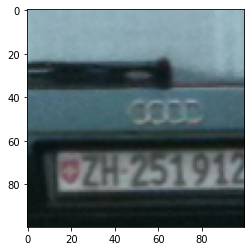

In [ ]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("./1.jpg", 0)
plt.imshow(img)

phone_image = tf.reshape(img, [-1, PATCH_HEIGHT, PATCH_WIDTH, 3])
print(phone_image.get_shape())
print(phone_image)

tf.Tensor(284980400.0, shape=(), dtype=float32)
Total variation(y) -  tf.Tensor(3.7262454, shape=(), dtype=float32)  Total variation(x) -  tf.Tensor(2.4772062, shape=(), dtype=float32)


<function destroyAllWindows>

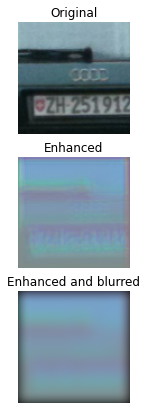

In [ ]:
#Gaussian Blur
import cv2
import matplotlib.pyplot as plt

#create figure 
fig = plt.figure(figsize=(10, 7)) 

img = plt.imread('./1.jpg')
img_blur = cv2.GaussianBlur(img, (21, 21), 3)

#plt.imshow(img_blur)

I = np.float32(np.reshape(img, [1, 100*100*3]))
phone_image = tf.reshape(I, [-1, PATCH_HEIGHT, PATCH_WIDTH, 3])
enhanced = residualnetwork(phone_image)

enhanced_blur = blur(enhanced)
img_blur_2 = blur(phone_image)
loss_color = tf.reduce_sum(tf.pow(enhanced_blur - img_blur_2, 2))

print(loss_color)

fig.add_subplot(3, 1, 1) 
plt.imshow(img)
plt.axis('off') 
plt.title("Original") 

fig.add_subplot(3, 1, 2)
plt.imshow(tf.squeeze(enhanced))
plt.axis('off') 
plt.title("Enhanced") 

fig.add_subplot(3, 1, 3)
plt.imshow(tf.squeeze(enhanced_blur))
plt.axis('off') 
plt.title("Enhanced and blurred") 

batch_shape = (batch_size, PATCH_WIDTH, PATCH_HEIGHT, 3)
#y -> vertical axis, x -> horizontal axis
tv_y_size = tensor_size(enhanced[:,1:,:,:])
tv_x_size = tensor_size(enhanced[:,:,1:,:])
#this is done to measure the difference between the values of the current pixel and the neighbouring pixel and find the l2 norm (output = sum(t ** 2) / 2)
y_tv = tf.nn.l2_loss(enhanced[:,1:,:,:] - enhanced[:,:batch_shape[1]-1,:,:])
x_tv = tf.nn.l2_loss(enhanced[:,:,1:,:] - enhanced[:,:,:batch_shape[2]-1,:])
loss_tv = 2 * (x_tv/tv_x_size + y_tv/tv_y_size) / batch_size

print("Total variation(y) - ", y_tv, " Total variation(x) - ", x_tv)

cv2.waitKey(0)
cv2.destroyAllWindows

In [ ]:
A = tf.reshape([[2,1,24],[4,5,6],[67,34,56]],[3,3,1])
print(A)

print(tf.argmax(A,1))

tf.Tensor(
[[[ 2]
  [ 1]
  [24]]

 [[ 4]
  [ 5]
  [ 6]]

 [[67]
  [34]
  [56]]], shape=(3, 3, 1), dtype=int32)
tf.Tensor(
[[2]
 [2]
 [0]], shape=(3, 1), dtype=int64)


In [ ]:
print(tf.constant(0.01, shape=[1024]))

A = tf.reshape([1,2,3],(3,1))
print(A)

B = tf.reshape([4,5,6], (3,1))
print(B)

print(tf.concat([A, B], 1))

tf.Tensor([0.01 0.01 0.01 ... 0.01 0.01 0.01], shape=(1024,), dtype=float32)
tf.Tensor(
[[1]
 [2]
 [3]], shape=(3, 1), dtype=int32)
tf.Tensor(
[[4]
 [5]
 [6]], shape=(3, 1), dtype=int32)
tf.Tensor(
[[1 4]
 [2 5]
 [3 6]], shape=(3, 2), dtype=int32)
